In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef

In [2]:
# Save the train and test DataFrames
X_TRAIN_DIR = "processed_data/glcm/X_train.pkl"
y_TRAIN_DIR = "processed_data/glcm/y_train.pkl"
X_TEST_DIR = "processed_data/glcm/X_test.pkl"
y_TEST_DIR = "processed_data/glcm/y_test.pkl"

X_train = pd.read_pickle(X_TRAIN_DIR)
y_train = pd.read_pickle(y_TRAIN_DIR)
X_test = pd.read_pickle(X_TEST_DIR)
y_test = pd.read_pickle(y_TEST_DIR)

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4129, 67)
(4129,)
(1030, 67)
(1030,)


In [86]:
X_train_exp = X_train.iloc[:, :61]
X_test_exp = X_test.iloc[:, :61]

33/33 [==============================] - 0s 845us/step


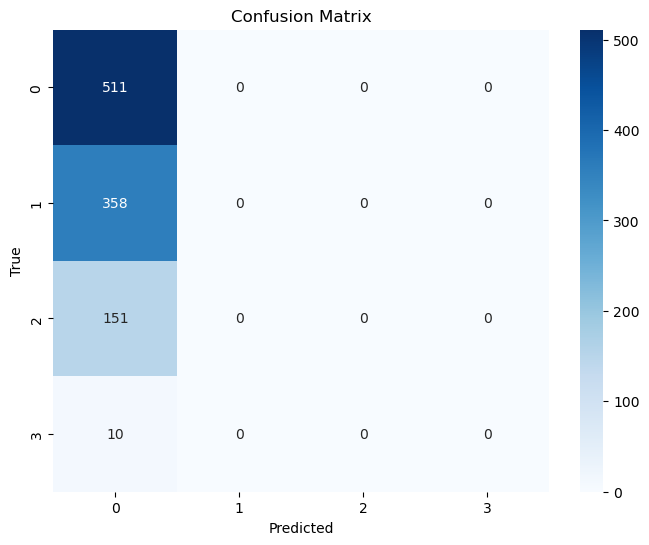

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       511
           1       0.00      0.00      0.00       358
           2       0.00      0.00      0.00       151
           3       0.00      0.00      0.00        10

    accuracy                           0.50      1030
   macro avg       0.12      0.25      0.17      1030
weighted avg       0.25      0.50      0.33      1030

Matthews Correlation Coefficient: 0.0
Weighted Average F2 Score: 0.4123545289039612


c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import backend as K

def weighted_categorical_crossentropy(weights):
    """
    Weighted categorical cross-entropy loss function.

    Parameters:
    weights (np.array): Array of weights for each class.

    Returns:
    loss function
    """
    weights = K.variable(weights)

    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

def tensorflow_neural_network_classification(X_train, y_train, X_test, y_test):
    """
    Perform neural network multiclass classification using TensorFlow, evaluate the model, and create a confusion matrix.

    Parameters:
    X_train (pd.DataFrame): Training features.
    y_train (pd.Series): Training labels.
    X_test (pd.DataFrame): Testing features.
    y_test (pd.Series): Testing labels.

    Returns:
    None
    """
    # One-hot encode the class labels
    y_train_encoded = to_categorical(y_train)
    y_test_encoded = to_categorical(y_test)

    # Create a label encoder
    label_encoder = LabelEncoder()

    # Encode the class labels
    encoder = label_encoder.fit_transform(y_train)

    # Get the class labels
    class_labels = label_encoder.classes_

    # Define a Sequential model
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(0.2),  
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(0.2),  
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(4, activation='softmax')  # Use softmax in the output layer
    ])

    # Create an instance of the FBetaScore class
    fbeta_score = tfa.metrics.FBetaScore(num_classes=4, beta=2.0, average='weighted')

    class_weights_dict = {0: 1, 1: 1.3, 2: 3, 3:40}

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[fbeta_score])

    # Train the model
    model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, verbose=0, class_weight=class_weights_dict)

    # Evaluate the model
    metrics = model.evaluate(X_test, y_test_encoded)

    # Predict labels
    y_pred_prob = model.predict(X_test)
    y_pred = [class_labels[idx] for idx in np.argmax(y_pred_prob, axis=1)]

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Calculate MCC using true labels and predicted labels
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews Correlation Coefficient:", mcc)

    # Calculate and print the weighted average F2 score
    weighted_f2_score = metrics[1]
    print("Weighted Average F2 Score:", weighted_f2_score)

tensorflow_neural_network_classification(X_train, y_train, X_test, y_test)
